In [6]:
%load_ext autoreload
%autoreload 2

import torch
# import torch_geometric.datasets as datasets
# from src.modules.gcn import GCN
from symb_xai.model.gin import GIN
import numpy as np
# import time
# import os
# import json
from symb_xai.visualization.plot_mutag import plot_molecule, plot_molecule_with_relevance
from symb_xai.dataset.load_mutag import load_dataset
from symb_xai.lrp.explain_mutag import lrp_gconv, lrp_linear
from itertools import product
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# funcs
from torch_geometric.utils import to_dense_adj
def get_model_temporary_res(model, x, edge_index):
    A = to_dense_adj(edge_index).squeeze()
    A += torch.eye(A.shape[0]) # add selfloop
    relu = list(model.gin.module_0.nn.modules())[1]
    module_temporary_res = [{} for _ in range(len(list(model.gin.modules())))]

    # model.gin.module_0: GINConv(nn=MLP(7, 32, 32))
    module_temporary_res[0]['out'] = A @ x

    module_temporary_res[0]['lin1'] = list(model.gin.module_0.nn.modules())[2][0]
    module_temporary_res[0]['lin2'] = list(model.gin.module_0.nn.modules())[2][1]

    module_temporary_res[0]['out1'] = relu(module_temporary_res[0]['out'] @ module_temporary_res[0]['lin1'].weight.T + module_temporary_res[0]['lin1'].bias) if model.bias else relu(module_temporary_res[0]['out'] @ module_temporary_res[0]['lin1'].weight.T)
    module_temporary_res[0]['out2'] = module_temporary_res[0]['out1'] @ module_temporary_res[0]['lin2'].weight.T + module_temporary_res[0]['lin2'].bias if model.bias else module_temporary_res[0]['out1'] @ module_temporary_res[0]['lin2'].weight.T

    # model.gin.module_1: ReLU(inplace=True)
    module_temporary_res[1]['out2'] = relu(module_temporary_res[0]['out2'])

    # model.gin.module_2: GINConv(nn=MLP(32, 32, 32))
    module_temporary_res[2]['out']  = A @ module_temporary_res[1]['out2']

    module_temporary_res[2]['lin1'] = list(model.gin.module_2.nn.modules())[2][0]
    module_temporary_res[2]['lin2'] = list(model.gin.module_2.nn.modules())[2][1]

    module_temporary_res[2]['out1'] = module_temporary_res[2]['out'] @ module_temporary_res[2]['lin1'].weight.T + module_temporary_res[2]['lin1'].bias if model.bias else module_temporary_res[2]['out'] @ module_temporary_res[2]['lin1'].weight.T
    module_temporary_res[2]['out1'] = relu(module_temporary_res[2]['out1'])
    module_temporary_res[2]['out2'] = module_temporary_res[2]['out1'] @ module_temporary_res[2]['lin2'].weight.T + module_temporary_res[2]['lin2'].bias if model.bias else module_temporary_res[2]['out1'] @ module_temporary_res[2]['lin2'].weight.T

    # model.gin.module_3: ReLU(inplace=True)
    module_temporary_res[3]['out2'] = relu(module_temporary_res[2]['out2'])

    # model.gin.module_4: GINConv(nn=MLP(32, 32, 32))
    module_temporary_res[4]['out'] = A @ module_temporary_res[3]['out2']

    module_temporary_res[4]['lin1'] = list(model.gin.module_4.nn.modules())[2][0]
    module_temporary_res[4]['lin2'] = list(model.gin.module_4.nn.modules())[2][1]

    module_temporary_res[4]['out1'] = module_temporary_res[4]['out'] @ module_temporary_res[4]['lin1'].weight.T + module_temporary_res[4]['lin1'].bias if model.bias else module_temporary_res[4]['out'] @ module_temporary_res[4]['lin1'].weight.T
    module_temporary_res[4]['out1'] = relu(module_temporary_res[4]['out1'])
    module_temporary_res[4]['out2'] = module_temporary_res[4]['out1'] @ module_temporary_res[4]['lin2'].weight.T + module_temporary_res[4]['lin2'].bias if model.bias else module_temporary_res[4]['out1'] @ module_temporary_res[4]['lin2'].weight.T

    # model.gin.module_5: ReLU(inplace=True)
    module_temporary_res[5]['out2'] = relu(module_temporary_res[4]['out2'])

    # model.linear
    linear_out = module_temporary_res[5]['out2'] @ model.linear.weight.T + model.linear.bias if model.bias else module_temporary_res[5]['out2'] @ model.linear.weight.T

    # Read-out function
    read_out = linear_out.sum(axis=0)

    assert read_out.isclose(model.forward(x, edge_index)).all()
    return module_temporary_res, linear_out


def subgraph_rel(x, edge_index, R_linear, S, rule_linear='gamma', gamma=0.2, debug=False):
    A = to_dense_adj(edge_index).squeeze()
    A += torch.eye(A.shape[0]) # add selfloop

    R = R_linear

    for step, layer in enumerate(range(4,0,-2)):
        R_ = torch.zeros_like(R)
        R_[S] = R[S]
        R = R_ 

        R = lrp_linear(x = module_temporary_res[layer]['out1'], 
                    W = module_temporary_res[layer]['lin2'].weight.T, 
                    b = module_temporary_res[layer]['lin2'].bias,
                    R = R, rule=rule_linear, gamma=gamma, debug=debug)
        R = lrp_linear(x = module_temporary_res[layer]['out'], 
                    W = module_temporary_res[layer]['lin1'].weight.T, 
                    b = module_temporary_res[layer]['lin1'].bias,
                    R = R, rule=rule_linear, gamma=gamma, debug=debug)
        R = lrp_gconv(x = module_temporary_res[layer - 1]['out2'], 
                A = A, 
                R = R, 
                debug=debug)

    R_ = torch.zeros_like(R)
    R_[S] = R[S]
    R = R_ 
    R = lrp_linear(x = module_temporary_res[0]['out1'], 
                W = module_temporary_res[0]['lin2'].weight.T, 
                b = module_temporary_res[0]['lin2'].bias,
                R = R, rule=rule_linear, gamma=gamma, debug=debug)
    R = lrp_linear(x = module_temporary_res[0]['out'], 
                W = module_temporary_res[0]['lin1'].weight.T, 
                b = module_temporary_res[0]['lin1'].bias,
                R = R, rule=rule_linear, gamma=gamma, debug=debug)
    R = lrp_gconv(x = x, 
                A = A, 
                R = R, debug=debug)
    return R[S].sum()


In [14]:
# from src.data.load import load_dataset 
dataset_name = 'Mutagenicity'
dataset = load_dataset(dataset_name)

from symb_xai.model.mutag_utils import load_best_model
model = load_best_model('biasedMutagenicity')

debug = False
rule_linear = 'gamma'
gamma = 0.2

Loaded model biasedMutagenicity_GIN_1701953871.pth with test accuracy 0.8456


In [ ]:
if False: # only train if we want to retrain the model
    from symb_xai.model.mutag_utils import train_model

    gcn_layers = 3
    mlp_layers = 3
    hidden_dim = 64
    bias=False

    model = GIN(hidden_dim=hidden_dim, input_dim=dataset.num_features, gcn_layers=gcn_layers, 
                mlp_layers=mlp_layers, nbclasses=dataset.num_classes, node_level=False, 
                directed=False, regression=False, bias=bias)

    architecture = 'GIN'
    # print(model.forward(dataset[0].x, dataset[0].edge_index))

    train_idx = np.random.choice(len(dataset), int(len(dataset)*0.8), replace=False)
    test_idx = np.setdiff1d(np.arange(len(dataset)), train_idx)

    learning_rate = 0.0005
    num_epochs = 1000
    train_model(model, dataset, train_idx, test_idx, learning_rate, num_epochs, dataset_name, 
                architecture, gcn_layers, mlp_layers, hidden_dim, test_epochs=20)

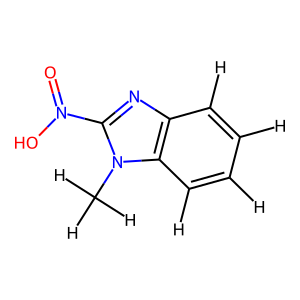

(None, tensor([0]))

In [15]:
data = dataset[33]
plot_molecule(data, dataset_name), data.y

In [16]:
x = data.x
edge_index = data.edge_index
module_temporary_res, linear_out = get_model_temporary_res(model, x, edge_index)

In [17]:
# init relevance -> pass the read-out step
target_class = model.forward(x, edge_index).argmax().item()
R_init = torch.zeros_like(linear_out)
R_init[:, target_class] = linear_out[:, target_class]

# model.linear 
R_linear = lrp_linear(x = module_temporary_res[5]['out2'], 
                W = model.linear.weight.T, 
                b = model.linear.bias,
                R = R_init,
                rule = 'gamma',
                gamma = 0.02,
                debug = debug)

In [18]:
R_walks = torch.zeros([R_linear.shape[0]]*4)
A = to_dense_adj(edge_index).squeeze()
A += torch.eye(A.shape[0]) # add selfloop
for walk in tqdm(product(range(R_linear.shape[0]),range(R_linear.shape[0]),range(R_linear.shape[0]))):
    if A[walk[0]][walk[1]] == 0 or A[walk[1]][walk[2]] == 0:
        continue
    walk = [-1] + list(walk)
    R = R_linear
    
    for step, layer in enumerate(range(4,0,-2)):
        R_ = torch.zeros_like(R)
        R_[walk[-step-1]] = R[walk[-step-1]]
        R = R_ 

        R = lrp_linear(x = module_temporary_res[layer]['out1'], 
                    W = module_temporary_res[layer]['lin2'].weight.T, 
                    b = module_temporary_res[layer]['lin2'].bias,
                    R = R, rule=rule_linear, gamma=gamma, debug=debug)
        R = lrp_linear(x = module_temporary_res[layer]['out'], 
                    W = module_temporary_res[layer]['lin1'].weight.T, 
                    b = module_temporary_res[layer]['lin1'].bias,
                    R = R, rule=rule_linear, gamma=gamma, debug=debug)
        R = lrp_gconv(x = module_temporary_res[layer - 1]['out2'], 
                A = A, 
                R = R, 
                debug=debug)

    R_ = torch.zeros_like(R)
    R_[walk[1]] = R[walk[1]]
    R = R_ 
    R = lrp_linear(x = module_temporary_res[0]['out1'], 
                W = module_temporary_res[0]['lin2'].weight.T, 
                b = module_temporary_res[0]['lin2'].bias,
                R = R, rule=rule_linear, gamma=gamma, debug=debug)
    R = lrp_linear(x = module_temporary_res[0]['out'], 
                W = module_temporary_res[0]['lin1'].weight.T, 
                b = module_temporary_res[0]['lin1'].bias,
                R = R, rule=rule_linear, gamma=gamma, debug=debug)
    R = lrp_gconv(x = x, 
                A = A, 
                R = R, debug=debug)
    R_walks[:, walk[1], walk[2], walk[3]] = R.sum(axis=1)

8000it [00:00, 30171.81it/s]


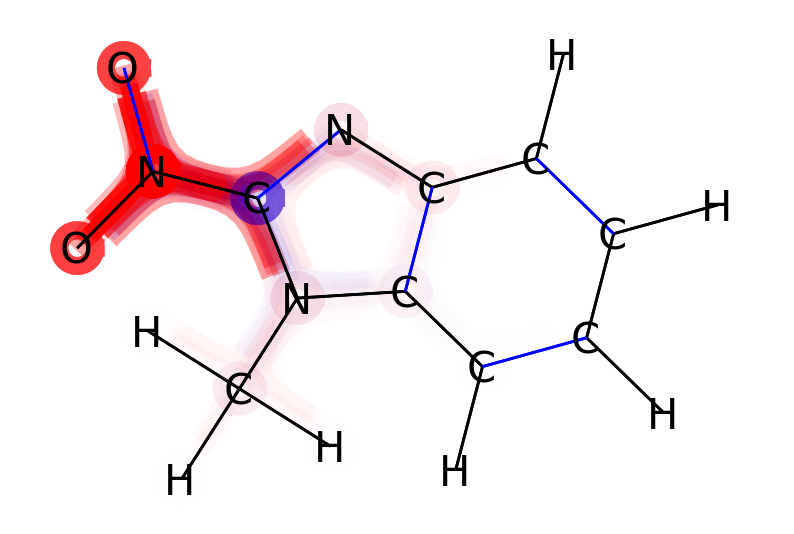

tensor([ 21.3499, -21.4280], grad_fn=<SumBackward1>) tensor([0]) tensor(51.0277)


In [19]:
relevances = []
for walk in product(range(R_linear.shape[0]),range(R_linear.shape[0]),range(R_linear.shape[0]),range(R_linear.shape[0])):
    if R_walks[walk] != 0:
        relevances.append((walk, float(R_walks[walk])))
plot_molecule_with_relevance(data, relevances, rel_level='walk', dataset_name=dataset_name, color_factor=0.2, legend=False, filename=None)
print(model(data.x, data.edge_index), data.y, R_walks.sum())

In [20]:
S = [1,2,3,4,5]
print(R_walks[S][:,S][:,:,S][:,:,:,S].sum())
print(subgraph_rel(x, edge_index, R_linear, S, rule_linear='gamma', gamma=0.2, debug=False))

tensor(0.3568)
tensor(0.3568)


In [ ]:
from torch_geometric.nn import Sequential

layers = []
for i in range(0,len(model.gin),2):
    conv, act = model.gin[i] ,model.gin[i+1]
    layer = Sequential('x, edge_index', [(conv, 'x, edge_index -> x'), act])
    layers.append(layer)
    
print(layers)

GINConv(nn=MLP(14, 64, 64)) ReLU(inplace=True)
GINConv(nn=MLP(64, 64, 64)) ReLU(inplace=True)
GINConv(nn=MLP(64, 64, 64)) ReLU(inplace=True)
[Sequential(
  (0) - GINConv(nn=MLP(14, 64, 64)): x, edge_index -> x
  (1) - ReLU(inplace=True): x -> x
), Sequential(
  (0) - GINConv(nn=MLP(64, 64, 64)): x, edge_index -> x
  (1) - ReLU(inplace=True): x -> x
), Sequential(
  (0) - GINConv(nn=MLP(64, 64, 64)): x, edge_index -> x
  (1) - ReLU(inplace=True): x -> x
)]


In [ ]:
from symb_xai.lrp.symbolic_xai import MutagenicitySymbXAI
from symb_xai.utils import powerset

explainer = MutagenicitySymbXAI(data,
                                model,
                                xai_mod=True,
                                gamma=.2,
                                scal_val=1.,
                                debug = False)

all_feature_ids = list(range(explainer.x.shape[0]))

all_subsets = powerset(all_feature_ids, K=3)
print('number of all subsets', len(all_subsets))

hars_div = {}
nb_zeros = 0
for subset in tqdm(all_subsets):
    hars_div[tuple(subset)] = explainer.harsanyi_div(subset)
    if hars_div[tuple(subset)] == 0.: nb_zeros+=1

print('number of zeros:', nb_zeros)
explainer.subgraph_relevance(all_feature_ids), sum([vals for vals in hars_div.values()])

number of all subsets 1350


100%|██████████| 1350/1350 [00:11<00:00, 121.85it/s]

number of zeros: 1283


(tensor(51.0277), tensor(43.1780))